# Exercise 2c
## Loïc Rosset, Nanae Aubry, Kilian Ruchti, Lionel Ieri

## Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from model_task2c import PR_CNN

## Load dataset

In [2]:
#path to dataset
mnist_train = "./../dataset/csv/mnist_train.csv"
mnist_test = "./../dataset/csv/mnist_test.csv"

In [3]:
def read_data(filename):
    df = pd.read_csv(filename, header=None)
    #data into numpy array
    data = df.iloc[:, 1:].values.reshape(-1, 1, 28, 28) /255.0
    labels = df.iloc[:, 0].values
    return data, labels

In [4]:
# Load the training and the test set
training_data, training_labels = read_data(mnist_train)
test_data, test_labels = read_data(mnist_test)

# Create validation data from training data
train_data, val_data, train_labels, val_labels = train_test_split(training_data, training_labels, test_size=0.1)

In [5]:
# Create MnistDataset for Pytorch in tensor format
class MnistDataset(Dataset):
    def __init__(self, data, label):
        # padding (left, right, top, bottom)
        tensor_data = torch.from_numpy(data.astype(np.float32))
        self.data = F.pad(input=tensor_data, pad=(1, 1, 1, 1), mode='constant', value=0)
        #self.data = tensor_data
        self.label = torch.from_numpy(label)
        self.n_samples = data.shape[0]
        
    def __getitem__(self, index):
        return self.data[index], self.label[index]
    
    def __len__(self):
        return self.n_samples

In [6]:
#Create dataset
train_dataset = MnistDataset(train_data, train_labels)
val_dataset = MnistDataset(val_data, val_labels)
test_dataset = MnistDataset(test_data, test_labels)

# Create data loader
params = {'batch_size': 32, 'shuffle': True}

train_loader = torch.utils.data.DataLoader(train_dataset, **params)
val_loader = torch.utils.data.DataLoader(val_dataset, **params)
test_loader = torch.utils.data.DataLoader(test_dataset, **params)

## Train CNN

In [7]:
def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

In [8]:
class Training():
    
    def __init__(self, nb_epochs=20, device=torch.device('cpu')):
        self.nb_epochs = nb_epochs
        self.device = device
    
    def train(self, model, train_loader, optimizer, loss_func):
        model.train()
        
        losses = []
        correct_train_pred = 0
        
        for data, labels in train_loader:
            data = data.to(self.device)
            labels = labels.to(self.device)
            
            # Predict the classes of the model
            output = model(data)
        
            optimizer.zero_grad()
            
            # Compute the loss
            loss = loss_func(output, labels)
            
            # Perform backprop
            loss.backward()
            optimizer.step()
            
            # Save current loss
            losses.append(loss.item())
            
            # Save the number of correct classified items
            predicted_labels = output.argmax(dim=1)
            nb_correct = (predicted_labels == labels).sum().item()
            correct_train_pred += nb_correct
    
        train_accuracy = 100. * (correct_train_pred / len(train_loader.dataset))
        
        return np.mean(np.array(losses)), train_accuracy
    
    def validation(self, model, val_loader, loss_func):
        model.eval()
        
        losses = []
        correct_val_predictions = 0
        
        with torch.no_grad():
            for data, labels in val_loader:
                data = data.to(self.device)
                labels = labels.to(self.device)
                
                output = model(data)
                
                loss = loss_func(output, labels)
                
                # Save current loss
                losses.append(loss.item())
    
                # Save the number of correct classified items
                predicted_labels = output.argmax(dim=1)
                n_correct = (predicted_labels == labels).sum().item()
                correct_val_predictions += n_correct
                
        val_accuracy = 100. * (correct_val_predictions / len(val_loader.dataset))
                
        return np.mean(np.array(losses)), val_accuracy

    def _print_info(self, train_loss, val_loss, train_acc, val_acc):
        print(f'Train_loss: {train_loss:.3f} |\
                Val_loss: {val_loss:.3f} |\
                Train_acc: {train_acc:.3f} |\
                Val_acc: {val_acc:.3f}')

    def fit(self, model, train_loader, val_loader, optimizer, loss_func):
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(self.nb_epochs):
            train_loss, train_acc = self.train(model, train_loader, optimizer, loss_func)
            val_loss, val_acc = self.validation(model, val_loader, loss_func)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

        self._print_info(train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1])

        return train_losses, val_losses, train_accuracies, val_accuracies

learning rate: 0.001
Train_loss: 0.419 |                Val_loss: 0.390 |                Train_acc: 88.448 |                Val_acc: 89.317
learning rate: 0.01
Train_loss: 0.207 |                Val_loss: 0.189 |                Train_acc: 94.228 |                Val_acc: 94.567
learning rate: 0.1
Train_loss: 0.053 |                Val_loss: 0.049 |                Train_acc: 98.407 |                Val_acc: 98.533


Best parameters: 0.1 learning_rate and validation accuracies: 98.53%


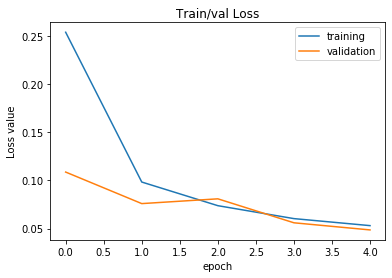

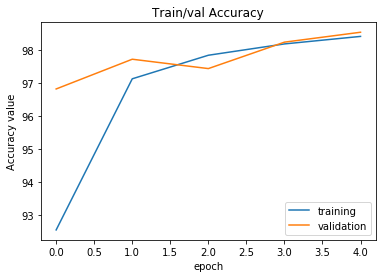

In [9]:
l_rate_set = [0.001, 0.01, 0.1]
nb_epochs = 5
trainer = Training(nb_epochs)

# best parameters: (validation acc, learning rate)
best_parameters = (float("-INF"), None, None)
# keep a copy of the best trained network
best_model = None

loss_function = nn.CrossEntropyLoss()

for l_rate in l_rate_set:
    cnn = PR_CNN()
    optimizer = torch.optim.SGD(cnn.parameters(), l_rate)
    
    # The training take place here :
    print(f'learning rate: {l_rate}')
    stats_training = trainer.fit(cnn, train_loader, val_loader, optimizer, loss_function)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], l_rate, stats_training)
        best_model = deepcopy(cnn)

best_acc, best_l_rate, best_stats = best_parameters
train_losses, val_losses, train_accuracies, val_accuracies = best_stats

print(f'\n\nBest parameters: {best_l_rate} learning_rate and validation accuracies: {best_acc:.2f}%')

plot_graph(nb_epochs, train_losses, val_losses, "Loss")
plot_graph(nb_epochs, train_accuracies, val_accuracies, "Accuracy")

## Accuracy on test set 

In [10]:
loss_test, acc_test = trainer.validation(best_model, test_loader, loss_function)
print(f'Accuracy on the test dataset {acc_test:.2f}%')

Accuracy on the test dataset 98.39%
